In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [2]:

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'text.latex.preamble': r"\usepackage{amsmath}"

}
plt.rcParams.update(tex_fonts)

In [3]:
settings_piflux = [
    "?name=piflux?J_pm=0.050?B=[0.000,0.000,0.000].jld",
    "?name=piflux?J_pm=0.050?B=[0.058,0.058,0.058].jld",
    "?name=piflux?J_pm=0.050?B=[0.000,0.071,0.071].jld"
]


SAVEPATH = "/Users/alaricsanders/Documents/gh-papers/Experimentally-Tunable-QED-in-DO-QSI/FIG"

SAVEPATH_POSTER = "/Users/alaricsanders/Desktop/figure_out"


In [11]:

phase_colors = dict(
flux0="#EDF2EF",
ππ00="#57C4E5",
πflux="#593a6d",
)


In [8]:
# general-purpose plot function


def plot_all(settings, titles=None, cmap=matplotlib.cm.magma, normalise_intensity=False, fig=None):
    subplot_settings = dict(nrows=3, ncols=len(settings)*2,sharex=False, sharey=False,
                            width_ratios=[3,0.5]*len(settings))
    if fig is None:
        fig, Ax = plt.subplots(**subplot_settings)
    else:
        Ax = fig.subplots(**subplot_settings)

    # autorange sweep
    spinon_max_E=-float("inf")
    intens_max_E=-float("inf")
    intens_max_Spm=-float("inf")
    intens_max_Smagnetic=-float("inf")
    
    for these_settings in settings:
        intensity_file = h5py.File("../output/SQW"+these_settings)
        fsp = h5py.File("../output/spinons"+these_settings)
        spinon_max_E = max(spinon_max_E, np.max(fsp["spinon_dispersion"]["bands"]))
        intens_max_E = max(intens_max_E, np.max(intensity_file["intensity"]["W"]))
        intens_max_Spm = max(intens_max_Spm, np.max(intensity_file["intensity"]["Spm"]["re_"]) )
        intens_max_Smagnetic = max(intens_max_Smagnetic, np.max(np.ma.masked_invalid(intensity_file["intensity"]["Smagnetic"])))
    
    
    for i, these_settings in enumerate(settings):
        intensity_file = h5py.File("../output/SQW"+these_settings)
    
        intens=intensity_file["intensity"]
        Ax[1][2*i].pcolormesh(intens["tau"], intens["W"], intens["Spm"]['re_'], 
                              shading='nearest',
                              rasterized=True, 
                              vmax=intens_max_Spm if normalise_intensity else None,
                              cmap=cmap
                             )
        Ax[2][2*i].pcolormesh(intens["tau"], intens["W"], intens["Smagnetic"],shading='nearest',
                              rasterized=True, 
                              vmax=intens_max_Smagnetic if normalise_intensity else None,
                              cmap=cmap
                             )
        
    
        for a in (Ax[1][2*i], Ax[2][2*i]):
            # a.plot(np.array(intens["tau"]), intens["bounds"][0], color='w',lw=0.4)
            # a.plot(np.array(intens["tau"]), intens["bounds"][1], color='w',lw=0.4)
            a.set_facecolor(cmap(0))
    
        xfontsize = 6
        
        Ax[1][2*i].set_xticks(intens["ticks_tau"], labels=[], fontsize=xfontsize)
        Ax[2][2*i].set_xticks(intens["ticks_tau"], 
                              labels=["$%s$"%(x.decode("UTF8")) for x in intens["ticks_label"]],
                              fontsize=xfontsize)
                  
    
        fsp = h5py.File("../output/spinons"+these_settings)
        spinon_intens = fsp["spinon_dispersion"]
        Ax[0][2*i].plot(np.array(spinon_intens["tau"]), np.array(spinon_intens["bands"]).T, color='k', lw=0.4)
        Ax[0][2*i].set_ylim([0,spinon_max_E+0.05])
        Ax[0][2*i].set_xticks(spinon_intens["ticks_tau"], labels=[], fontsize=xfontsize)
        Ax[0][2*i].set_xlim( [np.min(spinon_intens["ticks_tau"]), np.max(spinon_intens["ticks_tau"])])
    
        fint = h5py.File("../output/integrated"+these_settings)
        W = np.array(fint['intensity']['W'])
        Ax[1][2*i+1].plot(fint['intensity']['Spm']['re_'], W,color='k')
        Ax[2][2*i+1].plot(np.array(fint['intensity']['Smagnetic']), W,color='k')
        
        
        for a in [Ax[1][2*i+1], Ax[2][2*i+1]]:
        # Ax[1][2*i+1].set_ylim([min(W),max(W)])
        # Ax[2][2*i+1].set_ylim([min(W),max(W)])
            a.axis('off')
    
        for a in [Ax[1][2*i+1], Ax[1][2*i], Ax[2][2*i+1], Ax[2][2*i]]:
            a.set_ylim([0,intens_max_E])
    
        for j in range(3):
            Ax[j][2*i+1].set_yticklabels([])
            if i != 0:
                Ax[j][2*i].set_yticklabels([])
                
        
        Ax[0][2*i+1].axis('off')
        for j in [1,2]:
            a = Ax[j][2*i+1]
            a.set_xticks([])
            a.set_yticks([])
            # a.set_xlim([0,489384])
    
        phys = intensity_file["physical_parameters"]
        Bvec = eval(these_settings.split('?')[3][2:-4])
        print(f"Col {i}\n")
        print(f"\tFluxes: {np.mean(phys["emergent_fluxes"],axis=1)/np.pi}π ")
        print(f"\tJ_pm: {phys["Jpm"][()]}")
        print(f"\tB: {Bvec} ")
    
        
        B = np.linalg.norm(Bvec)
        Jpm = settings[i].split('?')[2][5:]

        if titles is None:
            Ax[0][2*i].set_title(r"$\|\boldsymbol{B}\|$=%.2f $J_{\pm}$=%s" % (B, Jpm) ,fontsize=9)
        else:
            Ax[0][2*i].set_title(titles[i],fontsize=9)
    
    for row in Ax:
        row[0].set_ylabel(r"$\omega/J_{y}$")

    
    # fig.tight_layout()
    return fig, Ax
    


In [81]:
## Form for posters and presentations

def plot_all_magnetic_only(settings, titles=None, cmap=matplotlib.cm.magma, normalise_intensity=False, pcm_args={}):
    fig, Ax = plt.subplots(nrows=2, ncols=len(settings)*2,sharex=False, sharey=False,width_ratios=[3,0.5]*len(settings))

    # autorange sweep
    spinon_max_E=-float("inf")
    intens_max_E=-float("inf")
    intens_max_Spm=-float("inf")
    intens_max_Smagnetic=-float("inf")
    
    for these_settings in settings:
        intensity_file = h5py.File("output/SQW"+these_settings)
        fsp = h5py.File("output/spinons"+these_settings)
        spinon_max_E = max(spinon_max_E, np.max(fsp["spinon_dispersion"]["bands"]))
        intens_max_E = max(intens_max_E, np.max(intensity_file["intensity"]["W"]))
        intens_max_Spm = max(intens_max_Spm, np.max(intensity_file["intensity"]["Spm"]["re_"]) )
        if 'vmax' in pcm_args:
            intens_max_Smagnetic = pcm_args['vmax']
        intens_max_Smagnetic = max(intens_max_Smagnetic, np.max(np.ma.masked_invalid(intensity_file["intensity"]["Smagnetic"])))
    
    
    for i, these_settings in enumerate(settings):
        intensity_file = h5py.File("output/SQW"+these_settings)
    
        intens=intensity_file["intensity"]
       
        Ax[1][2*i].pcolormesh(intens["tau"], intens["W"], intens["Smagnetic"],shading='nearest',
                              rasterized=True, 
                              vmax=intens_max_Smagnetic if normalise_intensity else None,
                              cmap=cmap
                             )
        
        Ax[1][2*i].set_facecolor(cmap(0))
        Ax[1][2*i].set_xticks(intens["ticks_tau"], labels=["$%s$"%(x.decode("UTF8")) for x in intens["ticks_label"]])
                  
    
        fsp = h5py.File("output/spinons"+these_settings)
        spinon_intens = fsp["spinon_dispersion"]
        Ax[0][2*i].plot(np.array(spinon_intens["tau"]), np.array(spinon_intens["bands"]).T, color='k', lw=0.4)
        Ax[0][2*i].set_ylim([0,spinon_max_E+0.05])
        Ax[0][2*i].set_xticks(spinon_intens["ticks_tau"], labels=[])
        Ax[0][2*i].set_xlim( [np.min(spinon_intens["ticks_tau"]), np.max(spinon_intens["ticks_tau"])])
    
        fint = h5py.File("output/integrated"+these_settings)
        W = np.array(fint['intensity']['W'])
        Ax[1][2*i+1].plot(np.array(fint['intensity']['Smagnetic']), W,color='k')
        
        Ax[1][2*i+1].axis('off')
    
        for a in [Ax[1][2*i+1], Ax[1][2*i]]:
            a.set_ylim([0,intens_max_E])
    
        for j in range(2):
            Ax[j][2*i+1].set_yticklabels([])
            if i != 0:
                Ax[j][2*i].set_yticklabels([])
                
        
        Ax[0][2*i+1].axis('off')
        
        a = Ax[1][2*i+1]
        a.set_xticks([])
        a.set_yticks([])
    
        phys = intensity_file["physical_parameters"]
        Bvec = eval(these_settings.split('?')[3][2:-4])
        print(f"Col {i}\n")
        print(f"\tFluxes: {np.mean(phys["emergent_fluxes"],axis=1)/np.pi}π ")
        print(f"\tJ_pm: {phys["Jpm"][()]}")
        print(f"\tB: {Bvec} ")
    
        
        B = np.linalg.norm(Bvec)
        Jpm = settings[i].split('?')[2][5:]

        if titles is None:
            Ax[0][2*i].set_title(r"$\|\boldsymbol{B}\|$=%.2f $J_{\pm}$=%s" % (B, Jpm) ,fontsize=9)
        else:
            Ax[0][2*i].set_title(titles[i],fontsize=9)
    
    for row in Ax:
        row[0].set_ylabel(r"$\omega/J_{y}$")
    
    fig.tight_layout()

    return fig, Ax

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'output/SQW?name=0flux?J_pm=-0.040?B=[0.000,0.071,0.071].jld', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

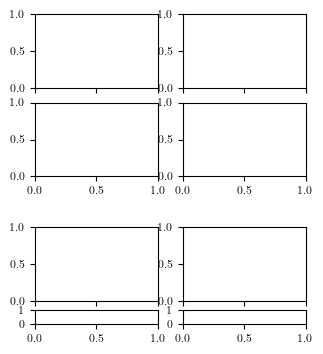

In [29]:
# FINAL PLOT FOR MAIN FIGURE
fig = plt.figure(figsize=(3.5,3.5))
subfigs = fig.subfigures(2, 1, [0,0,1,1],hspace=0.07, height_ratios=[2, 1.2])
Ax = subfigs[0].subplots(2, 2, sharex=True, sharey=False)
Ax2 = subfigs[1].subplots(2, 2, sharex=True, height_ratios=[2, 0.4])

#  110   111
# [ 0flux , FF ]
# [ ππ00, πflux ]
# [ ππ00-tune, πflux-tune]

settings=[
    "?name=0flux?J_pm=-0.040?B=[0.000,0.071,0.071].jld",
    # "?name=FF?J_pm=-0.010?B=[0.080,0.080,0.080].jld",
    # "?name=TEST_FF?J_pm=-0.030?B=[0.131,0.131,0.131].jld",
    # "?name=FF?J_pm=-0.040?B=[0.170,0.170,0.170].jld",
    "?name=pipi00?J_pm=-0.040?B=[0.000,0.204,0.204].jld",
    "?name=piflux?J_pm=0.300?B=[0.058,0.058,0.058].jld"
]

settings_sweep = [
    "int_fieldsweep?name=mix_pipi00?J_pm=-0.040?B=[0.000,0.000,0.000].jld",
    "int_fieldsweep?name=piflux-along?J_pm=0.300?B=[0.000,0.000,0.000].jld"
]
    

# cmap=matplotlib.cm.gnuplot
cmap=matplotlib.cm.magma
cmap2=cmap

for j, (these_settings, ax) in enumerate(zip(settings, Ax.ravel())):
    intensity_file = h5py.File("output/SQW"+these_settings)
    intens=intensity_file["intensity"]
            
    c1 = ax.pcolormesh(intens["tau"], intens["W"], intens["Smagnetic"],shading='nearest',
                                  rasterized=True, 
                                  cmap=cmap
                                 )
    ax.set_facecolor(cmap(0))
    ax.set_xticks(intens["ticks_tau"], labels=[])

labels = [r'a) 0-flux, $B\|[011]$',r'b) FF, $B\|[111]$',r'c) $\pi\pi00$, $B\|[011]$',r'd) $\pi$-flux, $B\|[111]$']
# labels = [r'a) 0-flux',r'b) FF',r'c) $\pi\pi00$',r'd) $\pi$-flux']

for label, ax in zip(labels, Ax.ravel()):
    ax.text(0.05,0.8, label, transform=ax.transAxes, color='white',)
    
Ax[0][0].set_ylim([0,1.7])
Ax[0][1].set_ylim([0,1.9])

for a in [Ax[1][0], Ax2[0][0] ]:
    a.set_ylim([0,2.1])
for a in [Ax[1][1], Ax2[0][1] ]:
    a.set_ylim([0,3.4])

# for a in Ax.ravel():
#     a.set_ylim([0,3.4])

# for a in Ax2.ravel():
#     a.set_ylim([0,3.4])


for ax in Ax[1]:
    ax.set_xticks(intens["ticks_tau"], labels=["$%s$"%(x.decode("UTF8")) for x in intens["ticks_label"]])

for s, ax, ax2 in zip(settings_sweep, Ax2[0], Ax2[1]):
    data = h5py.File("output/"+s)
    intens = data['integrated_intensity']
    # print(intens.keys())
    c2 = ax.pcolormesh( intens['magnetic_field_strengths'], intens['W'], intens['Smagnetic'],
                    rasterized=True, 
                       shading='nearest',
                       cmap=cmap2)
    ax.set_facecolor(cmap2(0))
    ax2.set_xlim([np.min(intens['magnetic_field_strengths']), np.max(intens['magnetic_field_strengths'])])

for row in Ax2:
    row[0].axvline(
        np.linalg.norm(eval(settings[2].split('?')[3][2:][:-4])),
        color='w',lw=1,ls=':')

    row[1].axvline(
        np.linalg.norm(eval(settings[3].split('?')[3][2:][:-4])),
        color='w',lw=1,ls=':')


# Ax[0][0].set_title('110 field')
# Ax[0][1].set_title('111 field')

# ax2labels = [r'e) $B\| [110]$', r'f)~~~ $B\|[111]$']
ax2labels = [r'e) ~$J_\pm = -0.04$', r'f) ~$J_\pm = 0.3$']

for l,ax in zip(ax2labels,Ax2[0]):
    ax.text(0.05,0.8, l, transform=ax.transAxes, color='white',)
    


Ax[0][0].set_ylabel(r"$\omega/J_{y}$")
Ax[1][0].set_ylabel(r"$\omega/J_{y}$")
Ax2[0][0].set_ylabel(r"$\omega/J_{y}$")


SAVEPATH_FINAL = "/Users/alaricsanders/Documents/gh-papers/Experimentally-Tunable-QED-in-DO-QSI/FIG"
# fig.tight_layout()
top_top = 0.97
top_bottom = 0.1
Left = 0.12
Right = 0.88
subfigs[0].subplots_adjust(top=top_top,right=Right,left=Left,bottom=top_bottom)
cax = subfigs[0].add_axes([0.9,0.1,0.015,top_top-top_bottom])
subfigs[0].colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), orientation='vertical', cax=cax)

# Ax2[0][0].axvline(,color='green',lw=1)
bottom_top = 0.99
bottom_bottom = 0.33
# cax2 = subfigs[1].add_axes([0.9,bottom_bottom,0.02,bottom_top-bottom_bottom])
# subfigs[1].colorbar(matplotlib.cm.ScalarMappable(cmap=cmap2), orientation='vertical', cax=cax2)
subfigs[1].subplots_adjust(top=bottom_top,right=Right,left=Left,bottom=bottom_bottom,hspace=0)

for a in Ax2[1]:
    a.set_yticks([])
    a.set_ylim([0,1])

Bmin = np.sqrt(-9*-0.04/5)
Ax2[1][0].add_patch(matplotlib.patches.Rectangle((0,0), Bmin, 1, color=phase_colors['flux0']))
Ax2[1][0].text(Bmin/2,0.5,r"$U(1)_0$",horizontalalignment="center", verticalalignment="center",fontsize=8)
Ax2[1][0].add_patch(matplotlib.patches.Rectangle((Bmin,0), 1, 1, color=phase_colors['ππ00']))
Ax2[1][0].text(0.41,0.5,r"$\pi\pi00$",horizontalalignment="center", verticalalignment="center",fontsize=8)
Ax2[1][0].set_xlabel(r"$\|\boldsymbol{B}_{011}\|/J_{y}$")


Ax2[1][1].add_patch(matplotlib.patches.Rectangle((0,0), 1, 1, color=phase_colors['πflux']))
Ax2[1][1].text(0.25,0.5,r"$U(1)_\pi$",horizontalalignment="center", verticalalignment="center",fontsize=8,color='w')
Ax2[1][1].set_xlabel(r"$\|\boldsymbol{B}_{111}\|/J_{y}$")


# fig.savefig(SAVEPATH_FINAL+"/maintext-spinon.pdf",dpi=300)
fig.add_axes([0,0,1,1]).patch.set_alpha(0)


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../output/int_fieldsweep?name=piflux-along?J_pm=0.050?B=[0.000,0.000,0.000].jld', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

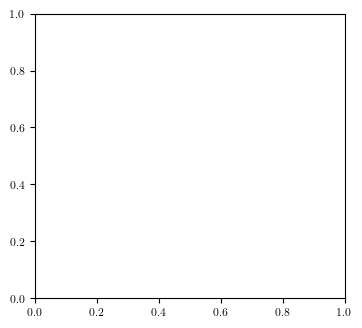

In [28]:
fig, ax = plt.subplots(figsize=(4,3.7))
data = h5py.File("../output/int_fieldsweep?name=piflux-along?J_pm=0.050?B=[0.000,0.000,0.000].jld")
intens = data['integrated_intensity']
# print(intens.keys())
c2 = ax.pcolormesh( intens['magnetic_field_strengths'], intens['W'], intens['Smagnetic'],
                rasterized=True, 
                   shading='nearest',
                   norm=matplotlib.colors.LogNorm(vmax=1e6,vmin=1e3),
                   # vmax=2000,
                   cmap=cmap2)
ax.set_facecolor(cmap2(0))
jpm = 0.05
Bc = np.sqrt(9 * jpm/5)
print(Bc)
plt.axvline(Bc,color='yellow')

Blims= [np.min(intens['magnetic_field_strengths']), np.max(intens['magnetic_field_strengths'])]

ax.set_xlim(Blims)
# ax.set_ylim([0,])
# ax.add_patch(matplotlib.patches.Rectangle((0,0), Bc/Blims[1], 0.2, color=phase_colors['πflux']))
targs = dict(
    horizontalalignment="center", verticalalignment="center",fontsize=14,color='w'
)

ax.text(0.15,2.5,r"$U(1)_\pi$",**targs)
ax.text(0.4, 2.5,r"$\pi\pi00$",**targs)
ax.set_xlabel(r"$\|\boldsymbol{B}_{110}\|/J_{y}$")
ax.set_title(r"$J_\pm = 0.05J_y$")
fig.colorbar(c2)
fig.tight_layout()
fig.savefig("/Users/alaricsanders/Desktop/figure_out/U(1)pi-pipi00")
fig.add_axes([0,0,1,1]).patch.set_alpha(0)

Col 0

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.04
	B: [0.0, 0.0, 0.0] 
Col 1

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.04
	B: [0.071, 0.071, 0.0] 
Col 2

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.04
	B: [0.058, 0.058, 0.058] 


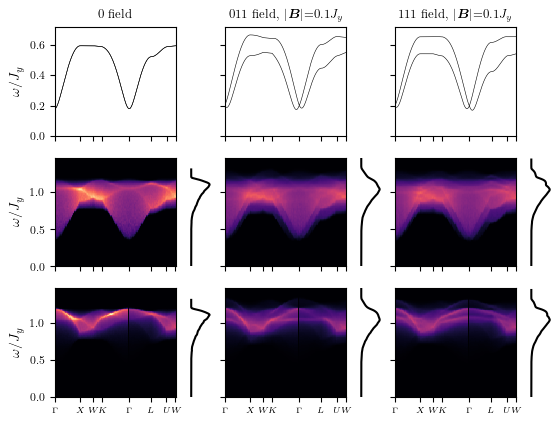

In [34]:
def parsinate_B(s):
    return np.linalg.norm(s.split('[')[-1].split(']')[0].split(','))



settings_0flux = [
    "?name=0flux?J_pm=-0.040?B=[0.000,0.000,0.000].jld",
    "?name=0flux?J_pm=-0.040?B=[0.071,0.071,0.000].jld",
    "?name=0flux?J_pm=-0.040?B=[0.058,0.058,0.058].jld"
]


titles = [
    "0 field",
    r"011 field, $|\boldsymbol{B}|$=%.1f$J_y$"% parsinate_B(settings_0flux[1]),
    r"111 field, $|\boldsymbol{B}|$=%.1f$J_y$"% parsinate_B(settings_0flux[1])
]
fig, Ax = plot_all(settings_0flux, titles, normalise_intensity=True)
# fig.savefig(SAVEPATH+"/0flux.pdf",dpi=300)
# fig.add_axes([0,0,1,1]).patch.set_alpha(0)

# fig, Ax = plot_all_magnetic_only(settings_0flux, titles, normalise_intensity=True)
# fig.savefig(SAVEPATH_POSTER+"/0flux.pdf",dpi=300)

In [ ]:


settings = [
    "?name=TEST_0flux?J_pm=-0.040?B=[0.000,0.000,0.000].jld",
    "?name=TEST_0flux?J_pm=-0.040?B=[0.000,0.071,0.071].jld",
    "?name=TEST_0flux?J_pm=-0.040?B=[0.058,0.058,0.058].jld"
]

titles = [
    "0 field",
    r"011 field, $|\boldsymbol{B}|$=%.1f"% parsinate_B(settings[1]),
    r"111 field, $|\boldsymbol{B}|$=%.1f"% parsinate_B(settings[2])
]
fig, Ax = plot_all(settings, titles, normalise_intensity=True)
# fig.savefig(SAVEPATH+"/0flux.pdf",dpi=300)
# fig.add_axes([0,0,1,1]).patch.set_alpha(0)

# fig, Ax = plot_all_magnetic_only(settings_0flux, titles, normalise_intensity=True)
# fig.savefig(SAVEPATH_POSTER+"/0flux.pdf",dpi=300)

Col 0

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: 0.3
	B: [0.0, 0.0, 0.0] 
Col 1

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: 0.3
	B: [0.071, 0.071, 0.0] 
Col 2

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: 0.3
	B: [0.058, 0.058, 0.058] 


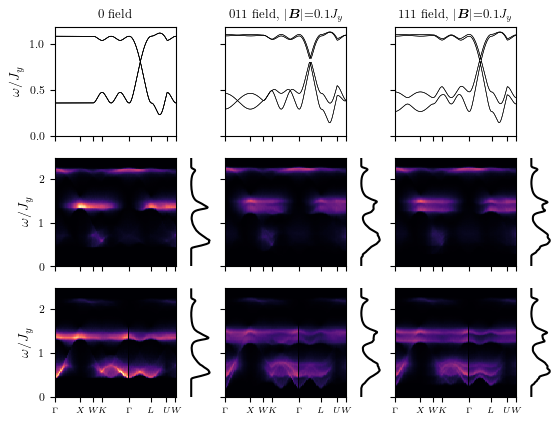

In [36]:
settings_piflux = [
    "?name=piflux?J_pm=0.300?B=[0.000,0.000,0.000].jld",
    "?name=piflux?J_pm=0.300?B=[0.071,0.071,0.000].jld",
    "?name=piflux?J_pm=0.300?B=[0.058,0.058,0.058].jld"
]

titles = [
    "0 field",
    r"011 field, $|\boldsymbol{B}|$=%.1f$J_y$"% parsinate_B(settings_piflux[1]),
    r"111 field, $|\boldsymbol{B}|$=%.1f$J_y$"% parsinate_B(settings_piflux[2])
]
fig, Ax = plot_all(settings_piflux, titles, normalise_intensity=True)
# fig.savefig(SAVEPATH+"/piflux.pdf",dpi=300)
# fig.add_axes([0,0,1,1]).patch.set_alpha(0)

In [ ]:

settings_pipi00 = [
    "?name=pipi00?J_pm=-0.040?B=[0.000,0.155,0.155].jld",
    "?name=pipi00?J_pm=-0.040?B=[0.000,0.213,0.213].jld",
    "?name=pipi00?J_pm=-0.040?B=[0.000,0.270,0.270].jld"
]

titles = [
    r"011 field, $|\boldsymbol{B}|$=%.2f$J_y$"% parsinate_B(settings_pipi00[0]),
    r"011 field, $|\boldsymbol{B}|$=%.2f$J_y$"% parsinate_B(settings_pipi00[1]),
    r"011 field, $|\boldsymbol{B}|$=%.2f$J_y$"% parsinate_B(settings_pipi00[2]),
]

fig, Ax = plot_all(settings_pipi00, titles)
# fig.savefig(SAVEPATH+"/pipi00-flux.pdf", dpi=300)

# fig, Ax = plot_all_magnetic_only(settings_pipi00)
# fig.savefig(SAVEPATH_POSTER+"/pipi00-flux.pdf", dpi=300)



In [ ]:
settings_FF = [
    # "?name=FF?J_pm=-0.040?B=[0.170,0.170,0.170].jld",
    "?name=TEST_FF?J_pm=-0.030?B=[0.131,0.131,0.131].jld",
    "?name=TEST_FF?J_pm=-0.030?B=[0.147,0.147,0.147].jld"
]



fig, Ax = plot_all(settings_FF)
# fig.savefig(SAVEPATH+"/FF-side-by-side.pdf",dpi=300)

In [ ]:
fig = plt.figure(figsize=(7, 6))
subfigs = fig.subfigures(2, 2, wspace=0.0, hspace=0)

titles_0fl = [
    "0 field",
    r"$B_{011}$=%.1f$J_y$"% parsinate_B(settings_0flux[1]),
    r"$B_{111}$=%.1f$J_y$"% parsinate_B(settings_0flux[2])
]

titles_pifl = [
    "0 field",
    r"$B_{011}$=%.1f$J_y$"% parsinate_B(settings_piflux[1]),
    r"$B_{111}$=%.1f$J_y$"% parsinate_B(settings_piflux[2])
]

titles_pi0fl = [
    r"$B_{011}=%.2f J_y$"% parsinate_B(settings_pipi00[0]),
    r"$B_{011}=%.2f J_y$"% parsinate_B(settings_pipi00[1]),
    r"$B_{011}=%.2f J_y$"% parsinate_B(settings_pipi00[2]),
]

titles_FF = [
    r"$B_{111}=%.2f J_y$"% parsinate_B(settings_FF[0]),
    r"$B_{111}=%.2f J_y$"% parsinate_B(settings_FF[1])
]

# titles_FF = [
#     r"$B_{111}=%.2f J_y,~\Phi=\frac{\pi}{6}$"% parsinate_B(settings_FF[0]),
#     r"$B_{111}=%.2f J_y,~\Phi=\frac{\pi}{4}$"% parsinate_B(settings_FF[1])
# ]

plot_all(settings_0flux, titles_0fl, fig=subfigs[0][0])
plot_all(settings_piflux, titles_pifl, fig=subfigs[0][1])
plot_all(settings_pipi00, titles_pi0fl, fig=subfigs[1][0])
_, ax_ff = plot_all(settings_FF, titles_FF, fig=subfigs[1][1])

for r in subfigs:
    for f in r:
        f.subplots_adjust(wspace=0.08, top=0.8, left=0.16, right=0.88, bottom=0.1)
        
        cax = f.add_axes([0.9,0.1,0.015,0.45])
        f.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), orientation='vertical', cax=cax)


subfigs[1][1]

hpos= 0.55
vpos = 0.9
subfigs[0][0].text(hpos,vpos, r"0-flux, $J_\pm$=-0.04", horizontalalignment="center", fontsize=14)
subfigs[0][1].text(hpos,vpos, r"$\pi$-flux, $J_\pm$=0.3", horizontalalignment="center", fontsize=14)
subfigs[1][0].text(hpos,vpos, r"$\pi\pi00$-flux, $J_\pm$=-0.04", horizontalalignment="center", fontsize=14)
subfigs[1][1].text(hpos,vpos, r"FF, $J_\pm$=-0.03", horizontalalignment="center", fontsize=14)

ax_ff[0][0].text(0.2,0.1,r"$\Phi={\pi}/{6}$", color='red')
ax_ff[0][2].text(0.2,0.1,r"$\Phi={\pi}/{4}$", color='red')

fig.tight_layout()

fig.savefig(SAVEPATH+"/grand-unified-spinons.pdf", dpi=300)

fig.add_axes([0,0,1,1]).patch.set_alpha(0)

In [ ]:
# FIELD SWEEP
fig = plt.figure(figsize=(4.5,2.4))

Ax2 = fig.subplots(2, 2, sharex=True, height_ratios=[2, 0.4])

#  011   111
# [ 0flux , FF ]
# [ ππ00, πflux ]
# [ ππ00-tune, πflux-tune]

# settings=[
#     "?name=0flux?J_pm=-0.046?B=[0.000,0.042,0.042].jld",
#     # "?name=FF-kludge?J_pm=-0.050?B=[0.224,0.224,0.224].jld",
#     "?name=FF-kludge?J_pm=-0.010?B=[0.100,0.100,0.100].jld",
#     "?name=pipi00+1e-4?J_pm=-0.050?B=[0.000,0.260,0.260].jld",
#     "?name=piflux-2?J_pm=0.333?B=[0.058,0.058,0.058].jld"
# ]

settings_sweep = [
    # "int_fieldsweep?name=pipi00-along?J_pm=-0.050?B=[0.577,0.577,0.577].jld",
    # "int_fieldsweep?name=pipi00-along?J_pm=-0.050?B=[0.577,0.577,0.577].jld",
    # "int_fieldsweep?name=TEST_mix_pipi00?J_pm=-0.050?B=[0.000,0.000,0.000].jld",
    # "int_fieldsweep?name=piflux-along?J_pm=0.333?B=[0.577,0.577,0.577].jld"
    "int_fieldsweep?name=mix_pipi00?J_pm=-0.040?B=[0.000,0.000,0.000].jld",
    # "int_fieldsweep?name=piflux-along-100?J_pm=0.300?B=[0.000,0.000,0.000].jld",
    # "int_fieldsweep?name=piflux-along-110?J_pm=0.300?B=[0.000,0.000,0.000].jld",
    "int_fieldsweep?name=piflux-along?J_pm=0.300?B=[0.000,0.000,0.000].jld"
]
    

# cmap=matplotlib.cm.gnuplot
cmap=matplotlib.cm.magma
cmap2=cmap
    
Ax2[0][0].set_ylim([0,2.1])
Ax2[0][1].set_ylim([0,3.4])


for s, ax, ax2 in zip(settings_sweep, Ax2[0], Ax2[1]):
    data = h5py.File("output/"+s)
    print(data['physical_parameters']['Jpm'][()])
    intens = data['integrated_intensity']
    # print(intens.keys())
    c2 = ax.pcolormesh( intens['magnetic_field_strengths'], intens['W'], intens['Smagnetic'],
                    rasterized=True, 
                       shading='nearest',
                       cmap=cmap2)
    ax.set_facecolor(cmap2(0))
    ax2.set_xlim([np.min(intens['magnetic_field_strengths']), np.max(intens['magnetic_field_strengths'])])

for row in Ax2:

    for b in [0.37, 0.49]:
        row[0].axvline(b,color='w',lw=1,ls=':')

    for b in [0,0.06]:
        row[1].axvline(b,color='w',lw=1,ls=':')


# Ax[0][0].set_title('110 field')
# Ax[0][1].set_title('111 field')

# ax2labels = [r'e) $B\| [110]$', r'f)~~~ $B\|[111]$']
ax2labels = [r'e) ~$J_\pm = -0.05$', r'f) ~$J_\pm = 1/3$']

# for l,ax in zip(ax2labels,Ax2[0]):
#     ax.text(0.05,0.8, l, transform=ax.transAxes, color='white',)


# Ax[0][0].set_ylabel(r"$\omega/J_{y}$")
# Ax[1][0].set_ylabel(r"$\omega/J_{y}$")
Ax2[0][0].set_ylabel(r"$\omega/J_{y}$")
Ax2[0][1].set_ylabel(r"$\omega/J_{y}$")

phase_colors = dict(
flux0="#EDF2EF",
ππ00="#57C4E5",
πflux="#593a6d",
)

# fig.tight_layout()
# top_top = 0.97
# top_bottom = 0.1
Left = 0.13
Right = 0.96
# subfigs[0].subplots_adjust(top=top_top,right=Right,left=Left,bottom=top_bottom)
# cax = subfigs[0].add_axes([0.9,0.1,0.015,top_top-top_bottom])
# subfigs[0].colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), orientation='vertical', cax=cax)

# Ax2[0][0].axvline(,color='green',lw=1)
bottom_top = 0.99
bottom_bottom = 0.19
# cax2 = subfigs[1].add_axes([0.9,bottom_bottom,0.02,bottom_top-bottom_bottom])
# subfigs[1].colorbar(matplotlib.cm.ScalarMappable(cmap=cmap2), orientation='vertical', cax=cax2)
fig.subplots_adjust(top=bottom_top,right=Right,left=Left,bottom=bottom_bottom,wspace=0.35,hspace=0)

for a in Ax2[1]:
    a.set_yticks([])
    a.set_ylim([0,1])

Bmin = np.sqrt(-9*-0.04/5)
Ax2[1][0].add_patch(matplotlib.patches.Rectangle((0,0), Bmin, 1, color=phase_colors['flux0']))
Ax2[1][0].text(Bmin/2,0.5,r"$U(1)_0$",horizontalalignment="center", verticalalignment="center",fontsize=8)
Ax2[1][0].add_patch(matplotlib.patches.Rectangle((Bmin,0), 1, 1, color=phase_colors['ππ00']))
Ax2[1][0].text(0.41,0.5,r"$\pi\pi00$",horizontalalignment="center", verticalalignment="center",fontsize=8)
Ax2[1][0].set_xlabel(r"$\|\boldsymbol{B}_{011}\|/J_{y}$")


Ax2[1][1].add_patch(matplotlib.patches.Rectangle((0,0), 1, 1, color=phase_colors['πflux']))
Ax2[1][1].text(0.25,0.5,r"$U(1)_\pi$",horizontalalignment="center", verticalalignment="center",fontsize=8,color='w')
Ax2[1][1].set_xlabel(r"$\|\boldsymbol{B}_{111}\|/J_{y}$")


# fig.savefig(SAVEPATH_POSTER+"/maintext-spinon-sweep.pdf",dpi=300)
# fig.add_axes([0,0,1,1]).patch.set_alpha(0)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'output/int_fieldsweep?name=piflux-along-100?J_pm=0.300?B=[0.000,0.000,0.000].jld', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

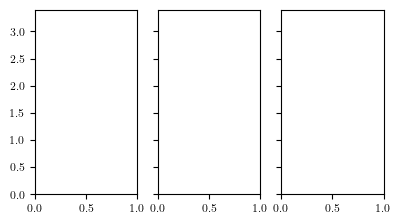

In [4]:
# FIELD SWEEP
fig = plt.figure(figsize=(4.5,2.4))



#  110   111
# [ 0flux , FF ]
# [ ππ00, πflux ]
# [ ππ00-tune, πflux-tune]

# settings=[
#     "?name=0flux?J_pm=-0.046?B=[0.000,0.042,0.042].jld",
#     # "?name=FF-kludge?J_pm=-0.050?B=[0.224,0.224,0.224].jld",
#     "?name=FF-kludge?J_pm=-0.010?B=[0.100,0.100,0.100].jld",
#     "?name=pipi00+1e-4?J_pm=-0.050?B=[0.000,0.260,0.260].jld",
#     "?name=piflux-2?J_pm=0.333?B=[0.058,0.058,0.058].jld"
# ]

settings_sweep = [
    # "int_fieldsweep?name=pipi00-along?J_pm=-0.050?B=[0.577,0.577,0.577].jld",
    # "int_fieldsweep?name=pipi00-along?J_pm=-0.050?B=[0.577,0.577,0.577].jld",
    # "int_fieldsweep?name=TEST_mix_pipi00?J_pm=-0.050?B=[0.000,0.000,0.000].jld",
    # "int_fieldsweep?name=piflux-along?J_pm=0.333?B=[0.577,0.577,0.577].jld"
    # "int_fieldsweep?name=mix_pipi00?J_pm=-0.040?B=[0.000,0.000,0.000].jld",
    "int_fieldsweep?name=piflux-along-100?J_pm=0.300?B=[0.000,0.000,0.000].jld",
    "int_fieldsweep?name=piflux-along-110?J_pm=0.300?B=[0.000,0.000,0.000].jld",
    "int_fieldsweep?name=piflux-along?J_pm=0.300?B=[0.000,0.000,0.000].jld"
]

Ax2 = fig.subplots(1, len(settings_sweep), sharex=True, sharey=True)
    

# cmap=matplotlib.cm.gnuplot
cmap=matplotlib.cm.magma
cmap2=cmap
    
Ax2[0].set_ylim([0,2.1])
Ax2[1].set_ylim([0,3.4])


for s, ax in zip(settings_sweep, Ax2):
    data = h5py.File("output/"+s)
    print(data['physical_parameters']['Jpm'][()])
    intens = data['integrated_intensity']
    # print(intens.keys())
    c2 = ax.pcolormesh( intens['magnetic_field_strengths'], intens['W'], intens['Smagnetic'],
                    rasterized=True, 
                       shading='nearest',
                       cmap=cmap2)
    ax.set_facecolor(cmap2(0))
    ax.set_ylim([0,2.8])
    


ax2labels = [r'e) ~$J_\pm = -0.05$', r'f) ~$J_\pm = 1/3$']

# for a in Ax2:
Ax2[0].set_ylabel(r"$\omega/J_{y}$")

phase_colors = dict(
flux0="#EDF2EF",
ππ00="#57C4E5",
πflux="#593a6d",
)

Left = 0.13
Right = 0.9

bottom_top = 0.88
bottom_bottom = 0.19
# cax2 = subfigs[1].add_axes([0.9,bottom_bottom,0.02,bottom_top-bottom_bottom])
# subfigs[1].colorbar(matplotlib.cm.ScalarMappable(cmap=cmap2), orientation='vertical', cax=cax2)
fig.subplots_adjust(top=bottom_top,right=Right,left=Left,bottom=bottom_bottom,wspace=0.1,hspace=0)

titles = [r'$B\|[%s]$' % s for s in ['100','110','111']]
for (a, l) in zip(Ax2, titles):
    a.set_title(l)
    a.set_xlabel("$B/J_y$")

cax = fig.add_axes([Right+0.01,bottom_bottom,0.015,bottom_top-bottom_bottom])
fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), orientation='vertical', cax=cax)

fig.savefig(SAVEPATH+"/rotated-piflux-sweep.pdf",dpi=300)

fig.add_axes([0,0,1,1]).patch.set_alpha(0)
    


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'output/int_fieldsweep?name=0flux-along-100?J_pm=-0.040?B=[0.000,0.000,0.000].jld', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

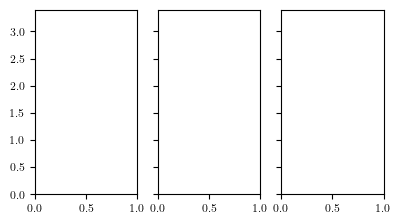

In [54]:
# FIELD SWEEP
fig = plt.figure(figsize=(4.5,2.4))



#  110   111
# [ 0flux , FF ]
# [ ππ00, πflux ]
# [ ππ00-tune, πflux-tune]

# settings=[
#     "?name=0flux?J_pm=-0.046?B=[0.000,0.042,0.042].jld",
#     # "?name=FF-kludge?J_pm=-0.050?B=[0.224,0.224,0.224].jld",
#     "?name=FF-kludge?J_pm=-0.010?B=[0.100,0.100,0.100].jld",
#     "?name=pipi00+1e-4?J_pm=-0.050?B=[0.000,0.260,0.260].jld",
#     "?name=piflux-2?J_pm=0.333?B=[0.058,0.058,0.058].jld"
# ]

settings_sweep = [
    # "int_fieldsweep?name=pipi00-along?J_pm=-0.050?B=[0.577,0.577,0.577].jld",
    # "int_fieldsweep?name=pipi00-along?J_pm=-0.050?B=[0.577,0.577,0.577].jld",
    # "int_fieldsweep?name=TEST_mix_pipi00?J_pm=-0.050?B=[0.000,0.000,0.000].jld",
    # "int_fieldsweep?name=piflux-along?J_pm=0.333?B=[0.577,0.577,0.577].jld"
    # "int_fieldsweep?name=mix_pipi00?J_pm=-0.040?B=[0.000,0.000,0.000].jld",
    "int_fieldsweep?name=0flux-along-100?J_pm=-0.040?B=[0.000,0.000,0.000].jld",
    "int_fieldsweep?name=0flux-along-110?J_pm=-0.040?B=[0.000,0.000,0.000].jld",
    "int_fieldsweep?name=0flux-along-111?J_pm=-0.040?B=[0.000,0.000,0.000].jld"
]

Ax2 = fig.subplots(1, len(settings_sweep), sharex=True, sharey=True)
    

# cmap=matplotlib.cm.gnuplot
cmap=matplotlib.cm.magma
cmap2=cmap
    
Ax2[0].set_ylim([0,2.1])
Ax2[1].set_ylim([0,3.4])


for s, ax in zip(settings_sweep, Ax2):
    data = h5py.File("output/"+s)
    print(data['physical_parameters']['Jpm'][()])
    intens = data['integrated_intensity']
    # print(intens.keys())
    c2 = ax.pcolormesh( intens['magnetic_field_strengths'], intens['W'], intens['Smagnetic'],
                    rasterized=True, 
                       shading='nearest',
                       cmap=cmap2)
    ax.set_facecolor(cmap2(0))
    ax.set_ylim([0,2.8])
    


ax2labels = [r'e) ~$J_\pm = -0.05$', r'f) ~$J_\pm = 1/3$']

# for a in Ax2:
Ax2[0].set_ylabel(r"$\omega/J_{y}$")

phase_colors = dict(
flux0="#EDF2EF",
ππ00="#57C4E5",
πflux="#593a6d",
)

Left = 0.13
Right = 0.96

bottom_top = 0.88
bottom_bottom = 0.19
# cax2 = subfigs[1].add_axes([0.9,bottom_bottom,0.02,bottom_top-bottom_bottom])
# subfigs[1].colorbar(matplotlib.cm.ScalarMappable(cmap=cmap2), orientation='vertical', cax=cax2)
fig.subplots_adjust(top=bottom_top,right=Right,left=Left,bottom=bottom_bottom,wspace=0.1,hspace=0)

titles = [r'$B\|[%s]$' % s for s in ['100','110','111']]
for (a, l) in zip(Ax2, titles):
    a.set_title(l)
    a.set_xlabel("$B/J_y$")


fig.add_axes([0,0,1,1]).patch.set_alpha(0)